TODO: 
- Need to take into account ties.
    - Right now, ties are ignored: does this make sense? From a ratings stand point, makes sense that teams' ratings would not increase or decrease; however, certainty of ratings should decrease after these matches.
        - Answer about variances: "variances are kept at $\sigma^2$"; thus, feels appropriate to ignore ties in this sense. 

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [170]:
from jax_elo.models.margin_model import fit, calculate_ratings, predict, get_player_skill_history
from jax_elo.utils.data import get_data
from jax_elo.utils.elo import optimise_static_k, compute_elo_ratings

In [4]:
mls_big = pd.read_csv('data/mls2001-2021.csv', low_memory=False)

In [81]:
mls_to_22 = mls_big[['home', 'away', 'date', 'year', 'venue', 'league', 'game_status', 'shootout', 'home_score', 'away_score', 
                    'part_of_competition']]

In [83]:
mlsRegularSeason = mls_to_22.loc[mls_to_22.part_of_competition.str.contains('Regular Season')].drop(columns='part_of_competition')
mlsRegularSeason.loc[mlsRegularSeason.shootout.isna(), 'shootout'] = False

In [123]:
mlsRegularSeason.loc[mlsRegularSeason['year'] < 2001, 'date_corrected'] = \
        pd.to_datetime(mlsRegularSeason.loc[mlsRegularSeason['year'] < 2001, 'date'], format="%m/%d/%Y")
mlsRegularSeason.loc[mlsRegularSeason['year'] >= 2001, 'date_corrected'] = \
        mlsRegularSeason.loc[mlsRegularSeason['year'] >= 2001, 'date'].str.cat(
            mlsRegularSeason.loc[mlsRegularSeason['year'] >= 2001, 'year'].apply(str), sep=", "
        )
mlsRegularSeason.loc[mlsRegularSeason['year'] >= 2001, 'date_corrected'] = \
        pd.to_datetime(mlsRegularSeason.loc[mlsRegularSeason['year'] >= 2001, 'date_corrected'], format="%A, %B %d, %Y")

In [124]:
mlsWL = mlsRegularSeason.copy() 
mlsWL['score_difference'] = mlsWL['home_score'] - mlsWL['away_score'] 
mlsWL['margin'] = np.abs(mlsWL['score_difference'])
mlsWL['winner'] = np.NaN
mlsWL['loser'] = np.NaN

mlsWL.loc[mlsWL['score_difference'] > 0, 'winner'] = mlsWL.loc[mlsWL['score_difference'] > 0, 'home']
mlsWL.loc[mlsWL['score_difference'] > 0, 'loser'] = mlsWL.loc[mlsWL['score_difference'] > 0, 'away']

mlsWL.loc[mlsWL['score_difference'] < 0, 'winner'] = mlsWL.loc[mlsWL['score_difference'] < 0, 'away']
mlsWL.loc[mlsWL['score_difference'] < 0, 'loser'] = mlsWL.loc[mlsWL['score_difference'] < 0, 'home']

mlsWL.loc[mlsWL['winner'] == 'Chicago', 'winner'] = 'Chicago Fire FC'
mlsWL.loc[mlsWL['winner'] == 'Colorado', 'winner'] = 'Colorado Rapids'
mlsWL.loc[mlsWL['winner'] == 'Columbus', 'winner'] = 'Columbus Crew SC'
mlsWL.loc[mlsWL['winner'] == 'Columbus Crew', 'winner'] = 'Columbus Crew SC'
mlsWL.loc[mlsWL['winner'] == 'DC United', 'winner'] = 'D.C. United'
mlsWL.loc[mlsWL['winner'] == 'Dallas', 'winner'] = 'FC Dallas'
mlsWL.loc[mlsWL['winner'] == 'Houston Dynamo', 'winner'] = 'Houston Dynamo FC'
mlsWL.loc[mlsWL['winner'] == 'Miami', 'winner'] = 'Inter Miami CF'
mlsWL.loc[mlsWL['winner'] == 'KC Wiz', 'winner'] = 'KC Wizards'
mlsWL.loc[mlsWL['winner'] == 'Montreal Impact', 'winner'] = 'CF Montréal'
mlsWL.loc[mlsWL['winner'] == 'New England', 'winner'] = 'New England Revolution'
mlsWL.loc[mlsWL['winner'] == 'San Jose', 'winner'] = 'San Jose Earthquakes'
mlsWL.loc[mlsWL['winner'] == 'MetroStars', 'winner'] = 'New York Red Bulls'
mlsWL.loc[mlsWL['winner'] == 'Tampa Bay', 'winner'] = 'Tampa Bay Mutiny'

mlsWL.loc[mlsWL['loser'] == 'Chicago', 'loser'] = 'Chicago Fire FC'
mlsWL.loc[mlsWL['loser'] == 'Colorado', 'loser'] = 'Colorado Rapids'
mlsWL.loc[mlsWL['loser'] == 'Columbus', 'loser'] = 'Columbus Crew SC'
mlsWL.loc[mlsWL['loser'] == 'Columbus Crew', 'loser'] = 'Columbus Crew SC'
mlsWL.loc[mlsWL['loser'] == 'DC United', 'loser'] = 'D.C. United'
mlsWL.loc[mlsWL['loser'] == 'Dallas', 'loser'] = 'FC Dallas'
mlsWL.loc[mlsWL['loser'] == 'Houston Dynamo', 'loser'] = 'Houston Dynamo FC'
mlsWL.loc[mlsWL['loser'] == 'Miami', 'loser'] = 'Inter Miami CF'
mlsWL.loc[mlsWL['loser'] == 'KC Wiz', 'loser'] = 'KC Wizards'
mlsWL.loc[mlsWL['loser'] == 'Montreal Impact', 'loser'] = 'CF Montréal'
mlsWL.loc[mlsWL['loser'] == 'New England', 'loser'] = 'New England Revolution'
mlsWL.loc[mlsWL['loser'] == 'San Jose', 'loser'] = 'San Jose Earthquakes'
mlsWL.loc[mlsWL['loser'] == 'MetroStars', 'loser'] = 'New York Red Bulls'
mlsWL.loc[mlsWL['loser'] == 'Tampa Bay', 'loser'] = 'Tampa Bay Mutiny'

In [125]:
to_use = mlsWL[['winner', 'loser', 'margin', 'date_corrected']]

In [127]:
# Fit the model
params, opt_info = fit(to_use['winner'], to_use['loser'], to_use['margin'].values, verbose=True)

theta: {'a1': 0.1, 'a2': array(0.), 'sigma_obs': 0.1, 'cov_mat': Array([[1.000001]], dtype=float64)}
cov_mat: [[1.000001]]
theta: {'a1': Traced<ShapedArray(float64[])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float64[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f95e389f580>, in_tracers=(Traced<ShapedArray(float64[]):JaxprTrace(level=2/0)>, Traced<ShapedArray(float64[]):JaxprTrace(level=2/0)>), out_tracer_refs=[<weakref at 0x7f95e56b85e0; to 'JaxprTracer' at 0x7f95e56b8900>], out_avals=[ShapedArray(float64[])], primitive=mul, params={}, effects=frozenset(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f95e4d1a5e0>, name_stack=NameStack(stack=(Transform(name='jvp'),)))), 'a2': Traced<ShapedArray(float64[])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float64

In [128]:
params

EloParams(theta={'a1': 0.0031337627968860303, 'a2': array(1.27451618), 'sigma_obs': 1.102405684230511, 'cov_mat': Array([[1436.54049732]], dtype=float64)})

In [129]:
# We can calculate the ratings over time:
history_df, rating_dict = calculate_ratings(params, to_use['winner'], to_use['loser'], to_use['margin'].values)

100%|█████████████████████████████████████| 6903/6903 [00:01<00:00, 5042.90it/s]


In [130]:
import pandas as pd

# Combine this with the other df
full_df = to_use.copy()
full_df = full_df.reset_index()
full_df = pd.concat([full_df, history_df], axis=1)

In [131]:
# We can predict matches using the final ratings, which are in rating_dict
predict(rating_dict, params, 'New York Red Bulls', 'New York City FC')

0.3898860255295228

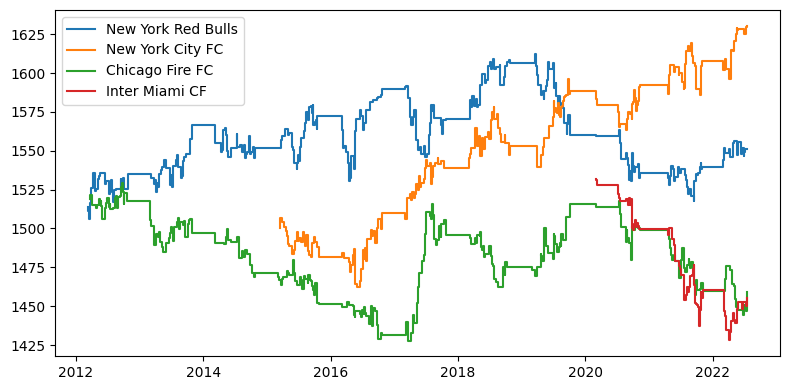

In [142]:
# We can plot the ratings over time
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(1, 1)

start_year = 2012

for cur_player in ['New York Red Bulls', 'New York City FC', 'Chicago Fire FC', 'Inter Miami CF']:

    history = get_player_skill_history(history_df, rating_dict, full_df['date_corrected'].values, cur_player)
    
    history = history[history.index >= f'{start_year}-01-01']
    ax.step(history.index, history.values, label=cur_player)
    
ax.legend()

f.set_size_inches(8, 4)
f.tight_layout()

In [134]:
# Finally, here's the prior standard deviation:
import numpy as np

prior_sd = np.sqrt(np.squeeze(params.theta['cov_mat']))
print(prior_sd)

37.90172156148


In [135]:
# How well does this predict?
# This gives the average log probability of the winner
# (aka negative log loss)
np.mean(np.log(history_df['winner_prior_prob']))

-0.6843323503912965

In [136]:
# Accuracy
np.mean(history_df['winner_prior_prob'] > 0.5)

0.42488772997247576

In [150]:
# Accurary after removing NaNs
np.mean(history_df.loc[~(history_df.winner.isna()), 'winner_prior_prob'] > 0.5)

0.566106929164254

In [137]:
# Compare with Elo:
from jax_elo.utils.elo import optimise_static_k, compute_elo_ratings

In [138]:
k, _ = optimise_static_k(to_use['winner'].values, to_use['loser'].values)

In [139]:
elo_results = pd.DataFrame(compute_elo_ratings(to_use['winner'].values, to_use['loser'].values, lambda _: k))

In [140]:
# Standard Elo has a lower log likelihood:
np.mean(np.log(elo_results['winner_prob']))

-0.687955272295096

In [141]:
# Accuracy
np.mean(elo_results['winner_prob'] > 0.5)

0.4170650441836882

In [157]:
# Accuracy after removing NaNs
np.mean(elo_results.loc[~(history_df.winner.isna()), 'winner_prob'] > 0.5)

0.5556842308434665

#### Refit margin model after dropping NaN's (that is, ties)

In [158]:
to_use_no_na = mlsWL[['winner', 'loser', 'margin', 'date_corrected']].dropna()

In [159]:
# Fit the model
params, opt_info = fit(to_use_no_na['winner'], to_use_no_na['loser'], to_use_no_na['margin'].values, verbose=True)

theta: {'a1': 0.1, 'a2': array(0.), 'sigma_obs': 0.1, 'cov_mat': Array([[1.000001]], dtype=float64)}
cov_mat: [[1.000001]]
theta: {'a1': Traced<ShapedArray(float64[])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float64[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f95e4902a10>, in_tracers=(Traced<ShapedArray(float64[]):JaxprTrace(level=2/0)>, Traced<ShapedArray(float64[]):JaxprTrace(level=2/0)>), out_tracer_refs=[<weakref at 0x7f95e365b400; to 'JaxprTracer' at 0x7f95e365b360>], out_avals=[ShapedArray(float64[])], primitive=mul, params={}, effects=frozenset(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f95e2156bd0>, name_stack=NameStack(stack=(Transform(name='jvp'),)))), 'a2': Traced<ShapedArray(float64[])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float64

In [160]:
params

EloParams(theta={'a1': 0.0018197273580205337, 'a2': array(1.70626307), 'sigma_obs': 0.9598421093345344, 'cov_mat': Array([[2026.70764856]], dtype=float64)})

In [161]:
# We can calculate the ratings over time:
history_df, rating_dict = calculate_ratings(params, to_use_no_na['winner'], to_use_no_na['loser'], 
                                            to_use_no_na['margin'].values)

100%|█████████████████████████████████████| 5181/5181 [00:00<00:00, 7211.63it/s]


In [162]:
# Combine this with the other df
full_df = to_use_no_na.copy()
full_df = full_df.reset_index()
full_df = pd.concat([full_df, history_df], axis=1)

In [163]:
# We can predict matches using the final ratings, which are in rating_dict
predict(rating_dict, params, 'New York Red Bulls', 'New York City FC')

0.38533232087623864

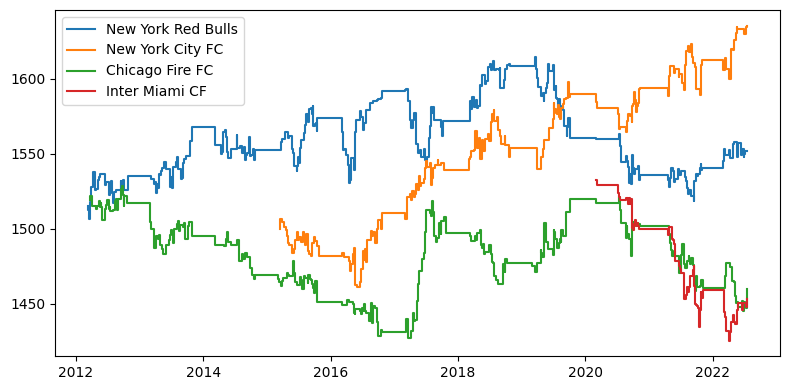

In [165]:
# We can plot the ratings over time
f, ax = plt.subplots(1, 1)

start_year = 2012

for cur_player in ['New York Red Bulls', 'New York City FC', 'Chicago Fire FC', 'Inter Miami CF']:

    history = get_player_skill_history(history_df, rating_dict, full_df['date_corrected'].values, cur_player)
    
    history = history[history.index >= f'{start_year}-01-01']
    ax.step(history.index, history.values, label=cur_player)
    
ax.legend()

f.set_size_inches(8, 4)
f.tight_layout()

In [166]:
# Finally, here's the prior standard deviation:
prior_sd = np.sqrt(np.squeeze(params.theta['cov_mat']))
print(prior_sd)

45.01896987453064


In [167]:
# How well does this predict?
# This gives the average log probability of the winner
# (aka negative log loss)
np.mean(np.log(history_df['winner_prior_prob']))

-0.6814055013494467

In [168]:
# Accuracy
np.mean(history_df['winner_prior_prob'] > 0.5)

0.5651418645049219

In [169]:
# Accurary after removing NaNs
np.mean(history_df.loc[~(history_df.winner.isna()), 'winner_prior_prob'] > 0.5)

0.5651418645049219

In [172]:
k, _ = optimise_static_k(to_use_no_na['winner'].values, to_use_no_na['loser'].values)

In [177]:
elo_results = pd.DataFrame(compute_elo_ratings(to_use_no_na['winner'].values, to_use_no_na['loser'].values, lambda _: k))

In [178]:
# Standard Elo has a lower log likelihood:
np.mean(np.log(elo_results['winner_prob']))

-0.6862296467340131

In [179]:
# Accuracy
np.mean(elo_results['winner_prob'] > 0.5)

0.5556842308434665

In [180]:
# Accuracy after removing NaNs
np.mean(elo_results.loc[~(history_df.winner.isna()), 'winner_prob'] > 0.5)

0.5556842308434665